# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка данных и первичный анализ

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb

import sklearn
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor


import re
import time 
import warnings 
p_random_state = 12345

In [2]:
#data = pd.read_csv('/datasets/autos.csv', parse_dates=[0,12,15])
try:
    data = pd.read_csv('/datasets/autos.csv',parse_dates=[0,12,15])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv',parse_dates=[0,12,15])
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Данные загружены, изучим их более подробно. 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [4]:
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

По информации видим:
- есть пропуски в столбцах VehicleType,Gearbox,Model,FuelType,Repaired  - необходимо обработать
- наименования колонок желательно привести к каноническому виду - через подчеркивание


Построим гистограммы по признакам и соберем описательную статистику:

Рассмотрим RegistrationMonth:

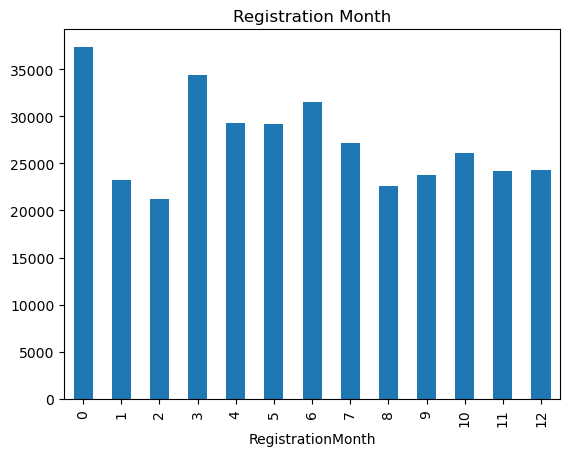

In [5]:
data.groupby(by=['RegistrationMonth'])['DateCrawled'].count().plot(kind='bar')
plt.title('Registration Month');


Среди значений видим, что есть аномальное значение 0 - такого месяца не бывает, поэтому будем далее исправлять данные объявления.

Признаки PostalCode и RegistrationYear содержат слишком много уникальных значений, поэтому рассмотрим данные только частично. Посмотрим уникальные значения в поле RegistrationYear и построим график только по данным с 1986 по 2023: 

[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]


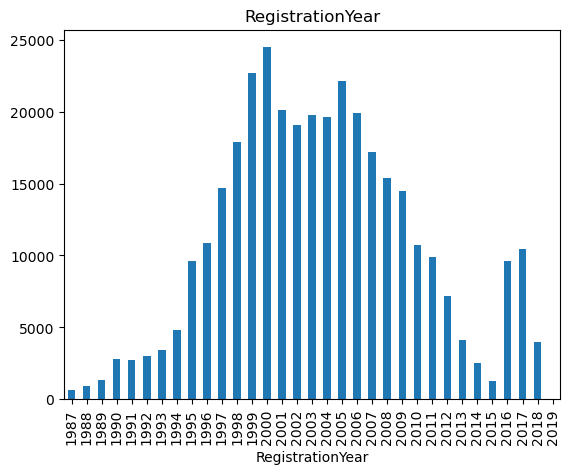

In [6]:
print(data['RegistrationYear'].sort_values().unique())
data[(data['RegistrationYear']>1986)&(data['RegistrationYear']<2023)].groupby(by=['RegistrationYear'])['DateCrawled'].count().plot(kind='bar')
plt.title('RegistrationYear');

Видим, что в поле достаточно много аномальных значений - от 1000 до 9999. Также аномальными являются значения >2016года, так как это год выгрузки информации из базы.

In [7]:
print('Количество уникальных значений в поле PostalCode:',data['PostalCode'].nunique())

Количество уникальных значений в поле PostalCode: 8143


Видим, что в базе более 8тыс.уникальных индексов. Строить график по всем 8тыс.значений не будем.
<br>Рассмотрим гистограммы по количественным признакам:

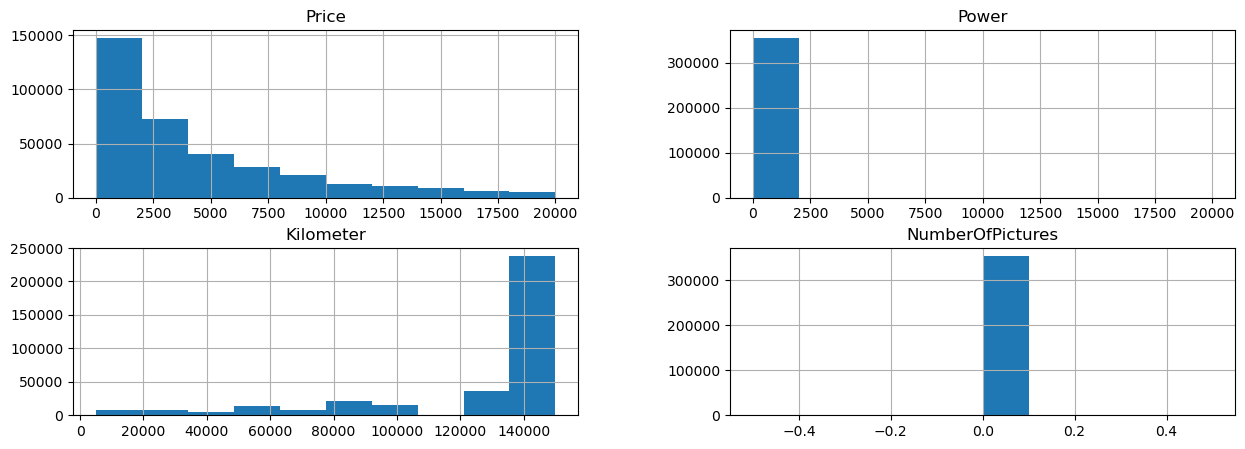

In [8]:
data[['Price','Power','Kilometer','NumberOfPictures']].hist(figsize=(15,5));

In [9]:
data.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369,354369.0,354369.000000,354369
mean,2016-03-21 12:58:10.450648320,4416.656776,2004.234448,110.094337,128211.172535,5.714645,2016-03-20 19:12:07.753274112,0.0,50508.689087,2016-03-29 23:51:00.667456768
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:51
75%,2016-03-29 14:37:20,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4514.158514,90.227958,189.850405,37905.341530,3.726421,NaN,0.0,25783.096248,NaN


По приведенным данным видим:
- по всем наблюдениям поле number_of_pictures заполнено значением 0 - это неинфомативное поле, можно его впоследствии удалить
- поле registration_year содержит значения вплоть до 9999 - необходимо более подробно изучить, являются ли значения больше текущего года заглушкой или аномалией. Если это аномалия, ее необходимо исправить. Также видим, что минимальное значение - 1000, это значение также необходимо исправить.
- поле power содержит аномальные значения 20000 - такой мощности скорее всего быть не может, аномальные значения необходимо удалить
- распределение цены (price) похоже на пуассоновское распределение с максимумом в 20тыс.евро, считаем данные приемлемыми. Некоторые машины действительно могут очень дорого стоить, если они раритетные, либо наоборот очень мощные и современные. Можно дополнительно посмотреть, что это за модели.
- поле с порбегом (kilometer) также выглядит правдоподобно: от 5тыс до 150тыс.км.
- поле registration_month в  целом выглядит красиво, однако смущают минимальыне значения 0, которых быть не должно. Ничего поделать с этим мы, скорее всего, не сможем, так как у нас нет полной даты регистрации, из которой можно было бы взять данное поле. 

Построим парные графики корреляции для датасета:

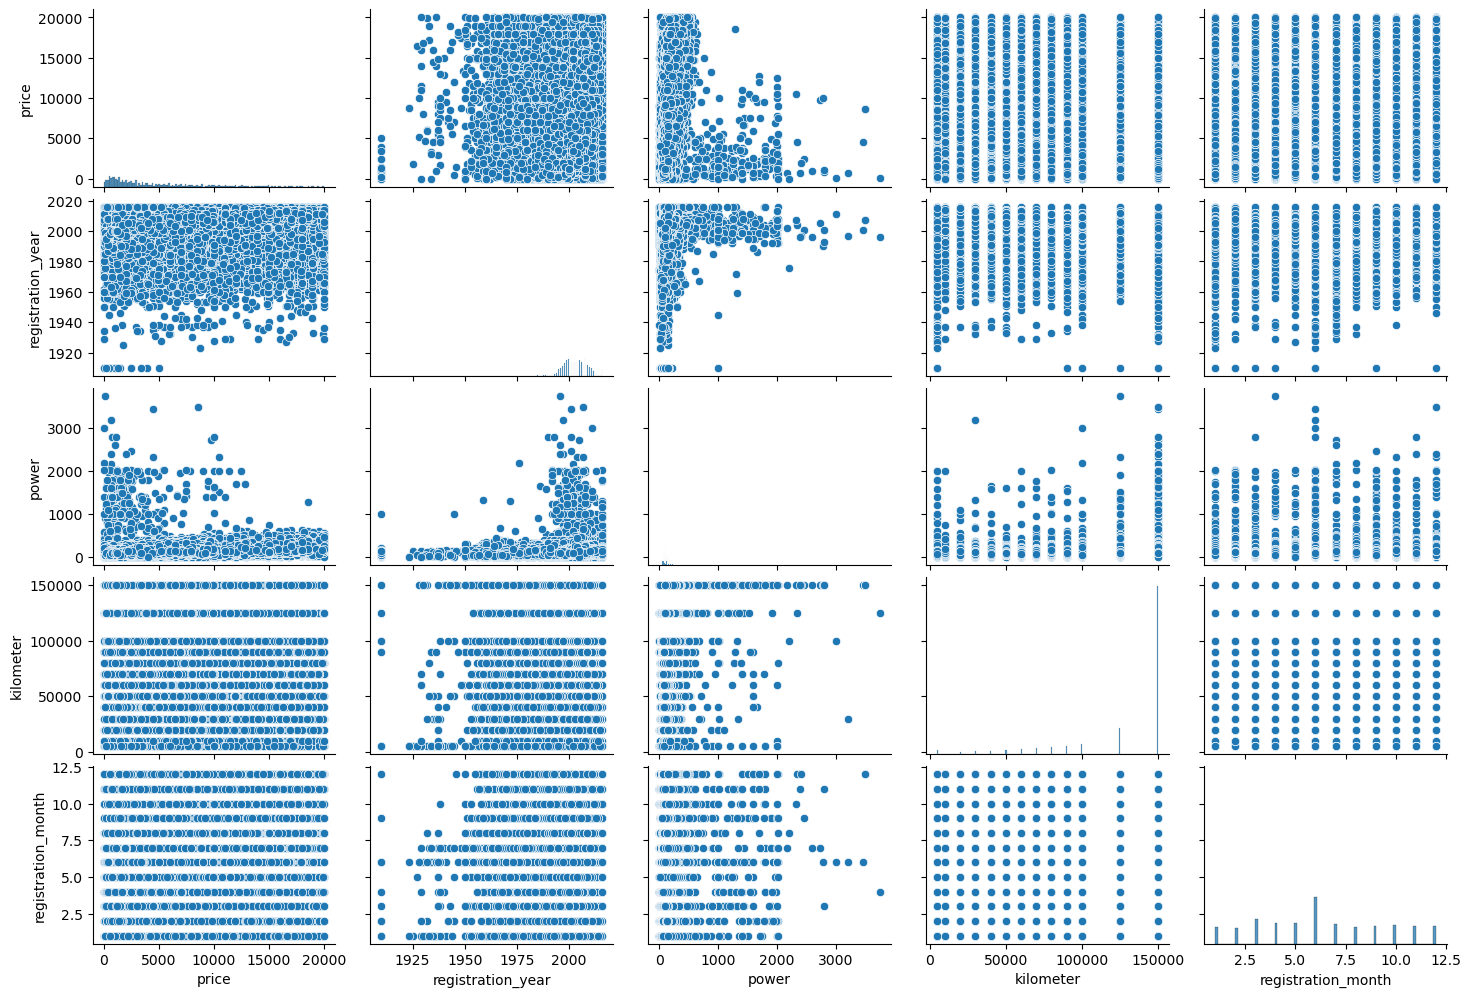

In [106]:
warnings.filterwarnings("ignore")
sns.pairplot(data)
plt.gcf().set_size_inches(15, 10)
plt.show()

В целом видим, что графики получились не очень информативными, так как в данных достаточно много аномальных значений (например, registration_year имеет значения вплоть до года 10000) а также потому признаки чаще всего не непрерывные (registration_year,registration_month), либо измеряюся в примерных значениях (например пробег измеряется в тысячах).
<br> Рассмотрим аномальные значения более подробно.

### Переименование столбцов

In [11]:
data = data.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower())     
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Исправление типов данных

Колонки с датами поправлены при загрузке:

In [12]:
data[['date_crawled','date_created','last_seen']].dtypes

date_crawled    datetime64[ns]
date_created    datetime64[ns]
last_seen       datetime64[ns]
dtype: object

In [13]:
data.head(2)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50


Поле postal_code хоть и содержит численные данные, по сути своей является категориальным (т.к. является численным кодом региона, а не мерой измерения чего-либо). Посмотрим, сколько уникальных значений содержится в поле. Если количество уникальных индексов примерно равно количеству наблюдений, то для обучения это поле будет бесполезно. Если, наоборот, количество индексов невелико относительно количества наблюдений, то возможно модель сможет уловить зависимость цены от региона продажи автомобиля и тогда поле будет полезно.

In [14]:
print('Количество уникальных индексов:',data['postal_code'].nunique())
data.groupby(by='postal_code')['date_crawled'].count().sort_values(ascending=False).head(15)

Количество уникальных индексов: 8143


postal_code
10115    819
65428    613
66333    343
32257    317
44145    317
52525    306
26789    296
78224    293
38518    291
13357    290
48599    289
48249    279
60311    276
51065    274
53757    273
Name: date_crawled, dtype: int64

В поле 8тыс. значений, причем по наиболее популярному региону - 10115 - около 800 наблюдений. Пока оставим данное поле, преобразуем его в строку и далее посмотрим, будет ли оно действительно полезно при обучении.

In [15]:
data['postal_code'] = data['postal_code'].astype('str')
data[['postal_code']].dtypes

postal_code    object
dtype: object

Типы данных скорректированы. Можно переходить к заполнению пропусков.

In [16]:
data['postal_code']

0         70435
1         66954
2         90480
3         91074
4         60437
          ...  
354364     2694
354365    39576
354366    26135
354367    87439
354368    40764
Name: postal_code, Length: 354369, dtype: object

### Заполнение пропусков

Перед заполнением пропусков скопируем исходные данные в датафрейм data_original, чтобы иметь возможность сравнить данные до и после заполнения.

In [17]:
data_original = data.copy()
data_original.head(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


#### Model

In [18]:
print('Исходное количество пропусков в поле:',data['model'].isna().sum())

Исходное количество пропусков в поле: 19705


Рассмотрим пропуски по полю модели в разрезе брендов.

In [19]:
filled_model = data.groupby(by='brand')['model'].agg(['count','size'])
filled_model.columns = ['Заполнено', 'Всего']
filled_model['Заполнено, %'] = filled_model['Заполнено']*100/filled_model['Всего']
filled_model = filled_model.sort_values(by='Заполнено, %',ascending=False)
display(filled_model.style.format("{:.3f}").background_gradient(cmap='Blues', axis=0))

,Заполнено,Всего,"Заполнено, %"
brand,,,
mini,3140.000,3202.000,98.064
land_rover,532.000,545.000,97.615
dacia,878.000,900.000,97.556
skoda,5359.000,5500.000,97.436
jaguar,491.000,505.000,97.228
saab,510.000,526.000,96.958
volvo,3101.000,3210.000,96.604
seat,6672.000,6907.000,96.598
toyota,4449.000,4606.000,96.591


Видим, что по большинству брендов модели заполнены более чем на 80-90%. Исключением является sonstige_autos - это категория "прочие автомобили" - по ним модели не заполнены ни по одной из 3374 обьявлений.
<br> При таком небольшом проценте пропусков по каждому бренду, возможно есть смысл заполнить пропуски модой, т.е. наиболее часто встречающимся значением модели по каждому бренду (но это не точно).
<br> Посмотрим, есть ли у брендов наиболее часто встречающиеся модели и если да, то каков их процент среди всех моделей бренда. Выведем три наиболее популярные модели по каждому бренду.

In [20]:
filled_model_detail = data.groupby(by=['brand','model'])['date_crawled'].agg(['count'])
model_stats = filled_model_detail.merge(filled_model, on='brand',how='left')
model_stats.index = filled_model_detail.index
model_stats.columns = ['Кол-во модели','Заполнено (по бренду)','Всего (по бренду)','Заполнено, % (по бренду)']
model_stats['Кол-во модели,в % по бренду'] = 100*model_stats['Кол-во модели']/model_stats['Всего (по бренду)']
pd.set_option('display.max_rows', 400)
model_stats = pd.DataFrame(model_stats['Кол-во модели,в % по бренду'].groupby(['brand'], group_keys=False).nlargest(3))
display(model_stats.style.format("{:.3f}").background_gradient(cmap='Blues', axis=0))

Видим, что по некоторым брендам действительно есть сверхпопулярные модели (например, trabant 601 - 71%, или smart fortwo - 82%), однако по большинству брендов даже самые популярные модели занимают 20-40% от общего количества объявлений, т.е. внутри бренда данные достаточно разрозненные. Получается, моду брать нельзя, высок риск исказить данные. Видим также, что среди объявлений популярна заглушка "other" - возможно в форме пользователя для заполнения объявлений представлены не все модели. Либо данная категория создана искусственно на этапе выгрузки данных.
Стоит ли заполять пропуски значением "other"? Скорее всего нет, так как other предполагает, что модели нет среди уже имеющихся объявлений (особенно в случае если категория создана на этапе выгрузки), а например значение "unknown" будет говорить, что модель неизвестна (но в действительности ее значение может присутствовать среди имеющихся моделей). Таким образом, это разные по смыслу категории. 
<br> Заполним пропуски значением 'unknown'.

In [21]:
data['model'] = data['model'].fillna('unknown')
print('Количество пропусков в поле после заполнения:',data['model'].isna().sum())

Количество пропусков в поле после заполнения: 0


Пропуски заполнились.

#### VehicleType

Посмотрим, какие уникальные значения есть в столбце с типом кузова авто:

In [22]:
data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Есть следующие типы кузовов: 
- coupe - купе
- suv - кроссовер
- sedan - седан
- convertible - кабриолет
- bus - минивэн
- wagon - универсал
- other - другое

Посмотрим, как распределены данные по типу кузова среди различных моделей. Ниже в таблице синим цветом выделены наибольшие значения в строке, т.е. выделен наиболее популярный тип кузова для каждой модели.

In [23]:
vtypes = data.groupby(by=['brand','model','vehicle_type'], dropna=False)['date_crawled'].count()
display(vtypes.unstack(level=-1).style.format("{:.3f}").background_gradient(cmap='Blues', axis=1))

Если посмотреть внимательно на выведенную таблицу (она большая, но некоторые зависимости увидеть можно), то можно заметить, что по моделям "unknown" самые синие значения (а значит, наибольшие) находятся в столбце Nan, то есть там, где не указана модель автомобиля, там и тип кузова чаще всего не указан. В то время как по остальным категориям (включая категорию "other") тип кузова чаще всего указан.
<br> Однако, в категории other все равно могут быть намешаны разные типы авто с разными кузовами, поэтому для моделей other и unknown заполним пропуски по типу кузова также "unknown", а для всех остальных моделей укажем наиболее популярный тип кузова среди модели (если он есть, если нет - также unknown).

In [24]:
mlist=['other','unknown']
print('Пропусков vehicle_type по моделям other,unknown до заполнения:',data.query('model in @mlist')['vehicle_type'].isna().sum())
data.loc[(data['model'].isin(mlist))&(pd.isna(data['vehicle_type'])), 'vehicle_type'] = 'unknown'
print('Пропусков vehicle_type по моделям other,unknown после заполнения:',data.query('model in @mlist')['vehicle_type'].isna().sum())

Пропусков vehicle_type по моделям other,unknown до заполнения: 8687
Пропусков vehicle_type по моделям other,unknown после заполнения: 0


Для надежности создадим сначала новое поле и проверим, что заполнение сработает корректно.

In [25]:
data['vehicle_type_new'] = data.groupby(by=['brand','model'])['vehicle_type'].transform(
        lambda x: x.fillna((x.mode()[0] if x.count()!=0 else 'unknown' )))

In [26]:
data['vehicle_type'].isna().sum()

28803

In [27]:
data.head(2)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,vehicle_type_new
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,sedan
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,coupe


Проверим, что мы заполнили только пропуски и не перезаписали уже имеющиеся данные. Для этого посчитаем количество строк, где новое поле не совпадает со старым:

In [28]:
data[data['vehicle_type_new']!=data['vehicle_type']]['vehicle_type_new'].count()

28803

Количество строк как раз совпадает с количеством пропусков, значит, имеющиеся данные мы не перезаписали. Скопируем новое поле в уже имеющееся и удалим поле с постфиксом _new.

In [29]:
data['vehicle_type'] = data['vehicle_type_new']
data = data.drop(['vehicle_type_new'], axis=1 )
print('Количество пропусков по полю vehicle_type (всего): ',data['vehicle_type'].isna().sum())

Количество пропусков по полю vehicle_type (всего):  0


Поле корректно скопировалось и теперь не содержит пропусков.

#### Repaired

Поле содержит информацию, была ли машина в ремонте или нет. Раз поле не заполнено, считаем по умолчанию, что не была.

In [30]:
print('Исходное количество пропусков в поле:',data['repaired'].isna().sum())
data['repaired'] = data['repaired'].fillna('no')
print('Количество пропусков после заполнения:',data['repaired'].isna().sum())

Исходное количество пропусков в поле: 71154
Количество пропусков после заполнения: 0


Пропуски заполнились. Проверим, как заполнение повлияло на распределение данных.

#### Gearbox

Посмотрим на распределение поля Gearbox среди разных моделей и оценим, как стоит заполнять поле: значением unknown (исходя из предположения, что коробка может быть любая, либо модой, исходя из предположения, что коробка у модели чаще всего одного типа).

In [31]:
vtypes = data.groupby(by=['brand','model','gearbox'], dropna=False)['date_crawled'].count()
display(vtypes.unstack(level=-1).style.format("{:.3f}").background_gradient(cmap='Blues', axis=1))

По приведенной таблице видим, что для большинства моделей все-таки характерна какая-то одна коробка передач - либо ручная, либо автомат. Заполним значение модой - наиболее часто встречающимся типом КПП для каждой модели.

In [32]:
print('Исходное количество пропусков gearbox до заполнения:',data['gearbox'].isna().sum())
data['gearbox'] = data.groupby(by=['brand','model'])['gearbox'].transform(
        lambda x: x.fillna((x.mode()[0] if x.count()!=0 else 'unknown' )))
print('Количество пропусков gearbox после заполнения:',data['gearbox'].isna().sum())


Исходное количество пропусков gearbox до заполнения: 19833
Количество пропусков gearbox после заполнения: 0


Пропусков не осталось.

#### FuelType

Аналогично рассмотрим модели по типу топлива и оценим, как заполнять данное поле:

In [33]:
vtypes = data.groupby(by=['brand','model','fuel_type'], dropna=False)['date_crawled'].count()
display(vtypes.unstack(level=-1).style.format("{:.3f}").background_gradient(cmap='Blues', axis=1))

Видим, что есть разные типы топлива:
- cng - сжиженный газ(метан)
- lpg - сжиженный газ (пропан-бутан)
- electric - электричество
- gasoline - <s>дизельное топливо</s> бензин
- petrol - бензин
- hybrid - гибридный вид авто (электро+бензин)
- other - другие виды

<br>Также видим, что для каждой модели чаще всего характерен один определенный вид топлива (чаще всего - бензин, реже - остальные).
<br> Заменим значение gasoline на petrol и заполним пропуски в поле модой по каждой модели.

In [34]:
data['fuel_type'] = data['fuel_type'].replace('gasoline','petrol')
data['fuel_type'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [35]:
print('Исходное количество пропусков fuel_type до заполнения:',data['fuel_type'].isna().sum())
data['fuel_type'] = data.groupby(by=['brand','model'])['fuel_type'].transform(
        lambda x: x.fillna((x.mode()[0] if x.count()!=0 else 'unknown' )))
print('Количество пропусков fuel_type после заполнения:',data['fuel_type'].isna().sum())

Исходное количество пропусков fuel_type до заполнения: 32895
Количество пропусков fuel_type после заполнения: 0


**Вывод по процессу заполнения пропусков:**
- пропуски по полю Model были заполнены значением 'unknown', так как у большинства брендов довольно много различных моделей и выбрать из них какую-либо одну для заполнения по пропускам всего бренда было бы некорректно
- пропуски по полю vehicle_type (тип кузова) были заполнены следующим образом:
    - для моделей 'other' и 'unknown' пропуски заполнены значением 'unknown'
    - для остальных моделей (уже известных) пропуски заполнены наиболее популярным типом кузова среди данной модели
- пропуски по полю repaired заполнены значением 'no', так как если явно не указано, что машина была в ремонте, то счиатем, что она не ремонтировалась (не восстанавливалась)
- пропуски по полю gearbox заполнены модой по каждой модели, так как явно видна популярность какой-либо одной коробки передач по каждой модели
- аналогично заполнены пропуски по типу топлива (fuel_type) - модой по каждой модели, а также удалены неявные дублликаты - значение gasoline заменено на petrol, так как это название одного и того же бензина в разных странах.

### Изучение аномалий

#### Registration Year

Изучим, какие есть значения в поле года регистрации и сколько наблюдений им соответствуют.

In [36]:
data.groupby(by='registration_year')['date_crawled'].count()

registration_year
1000       37
1001        1
1039        1
1111        3
1200        1
1234        4
1253        1
1255        1
1300        2
1400        1
1500        5
1600        2
1602        1
1688        1
1800        5
1910      101
1915        1
1919        1
1920        1
1923        2
1925        1
1927        1
1928        2
1929        7
1930        3
1931        1
1932        3
1933        3
1934        3
1935        4
1936        3
1937       11
1938        8
1940        2
1941        2
1942        3
1943        4
1944        2
1945        4
1946        1
1947        2
1948        3
1949        1
1950       18
1951       12
1952        9
1953       14
1954       11
1955       15
1956       27
1957       13
1958       25
1959       32
1960      188
1961       41
1962       46
1963       57
1964       64
1965       82
1966      113
1967       99
1968      108
1969      118
1970      333
1971      167
1972      213
1973      173
1974      169
1975      143
1976      175
19

Рассмотрим более подробно объявления, где год регистрации меньше 1886 (год создания первого автомобиля), либо больше <s>2023</s> 2016(год выгрузки базы).

In [37]:
print('Общее количество наблюдений с аномальным годом регистрации:',data[(data['registration_year']<1886)|(data['registration_year']>2016)]['date_crawled'].count())

Общее количество наблюдений с аномальным годом регистрации: 14596


In [38]:
data[(data['registration_year']<1886)|(data['registration_year']>2016)]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
22,2016-03-23 14:52:51,2900,bus,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,sedan,2017,manual,125,c4,125000,4,petrol,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,sedan,2017,manual,80,golf,100000,1,petrol,volkswagen,no,2016-03-25,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,small,2017,manual,90,punto,150000,11,petrol,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,unknown,2018,manual,64,other,125000,3,petrol,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,bus,2017,manual,86,transit,150000,5,petrol,ford,no,2016-03-11,0,32339,2016-03-12 05:45:02
354140,2016-03-29 16:47:29,1000,wagon,2017,manual,101,a4,150000,9,petrol,audi,no,2016-03-29,0,38315,2016-04-06 02:44:27
354203,2016-03-17 00:56:26,2140,small,2018,manual,80,fiesta,150000,6,petrol,ford,no,2016-03-17,0,44866,2016-03-29 15:45:04
354253,2016-03-25 09:37:59,1250,small,2018,manual,0,corsa,150000,0,petrol,opel,no,2016-03-25,0,45527,2016-04-06 07:46:13


Мы не можем достоверно восстановить год регистрации автомобиля. Заполнять его заглушкой вроде 9999 будет некорректно, так как это может негативно сказаться на линейной регрессии. Заполнять текущим годом также не совсем корректно, так как в выборке аномалий есть автомобили с внушительным пробегом. Однако, мы помним, что данные по пробегу в целом выглядят правдоподобно. Исходя из того, что средний автомобиль проезжает в год 16-18тыс.км, мы можем по пробегу вычислить примерный год регистрации: поделить пробег на 18тыс и полученное целое число отнять от текущего года.

In [39]:
data['reg_year_calc'] = pd.Series(2016,index=data.index) - np.floor(pd.Series(data['kilometer']/18000))
data['reg_year_calc'] = data['reg_year_calc'].astype('int64')
data.loc[(data['registration_year']<1886)|(data['registration_year']>2016),['registration_year']] = \
data.loc[(data['registration_year']<1886)|(data['registration_year']>2016)]['reg_year_calc']

Проверим данные после исправления аномалий.

In [40]:
print('Общее количество наблюдений с аномальным годом регистрации:',data[(data['registration_year']<1886)|(data['registration_year']>2016)]['date_crawled'].count())

Общее количество наблюдений с аномальным годом регистрации: 0


<Axes: >

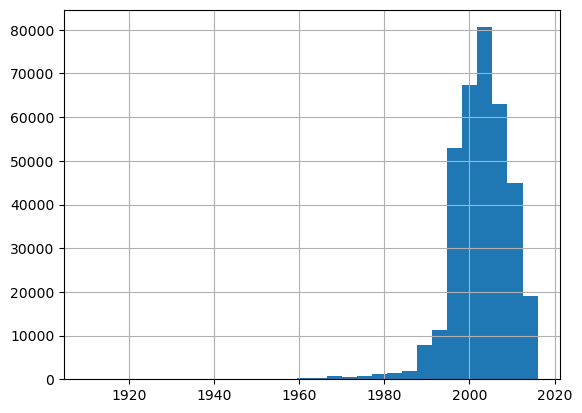

In [41]:
data['registration_year'].hist(bins=30)

Данные проапдейтились. Видим, что теперь значения выглядят более правдоподобно - нет огромной шкалы разброса от 1000 года до 9999-го.

Удалим расчетный столбец reg_year_calc

In [42]:
data = data.drop(['reg_year_calc'],axis=1)

#### Registration Month

В имеющихся данных есть объявления с нулевым месяцем регистрации.  Посмотрим, сколько таких случаев.

In [43]:
print('Случаев с нулевым месяцем регистрации:',data[data['registration_month']==0]['date_crawled'].count())

Случаев с нулевым месяцем регистрации: 37352


Таких случаев довольно много. Вероятнее всего, пользователь при заполнениии формы не указал месяц, либо он изначально указан неправильно. Так как корректный месяц из других полей мы восстановить не можем, то заполним его среединой года - 6м месяцем.

In [44]:
data.loc[data['registration_month']==0,'registration_month'] = 6
print('Случаев с нулевым месяцем регистрации:',data[data['registration_month']==0]['date_crawled'].count())

Случаев с нулевым месяцем регистрации: 0


#### Power

На данный момент максимальная мощность реально существующего авто - 4000л.с. В качестве минимальной мощности возьмем 1л.с.(мощность первого авто). Таким образом, все наблюдения с мощностью более 4тыс. и менее 1л.с. совершенно точно являются некорректными. Рассмотрим подробнее аномалии с мощностью 0 или более 4000л.с.

In [45]:
MIN_POWER=1 # константа: минимальная мощность авто
MAX_POWER=4000 # константа: максимальная мощность авто
print('Общее количество наблюдений с аномальной мощностью:',data[(data['power']<MIN_POWER)|(data['power']>MAX_POWER)]['date_crawled'].count())
print('Количество наблюдений с мощностью >4000л.с.: ',data[(data['power']>MAX_POWER)]['date_crawled'].count())
print('Количество наблюдений с мощностью <1 л.с.: ',data[(data['power']<MIN_POWER)]['date_crawled'].count())

Общее количество наблюдений с аномальной мощностью: 40313
Количество наблюдений с мощностью >4000л.с.:  88
Количество наблюдений с мощностью <1 л.с.:  40225


In [46]:
data[(data['power']>MAX_POWER)]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,no,2016-04-02,0,65830,2016-04-06 11:46:49
11039,2016-03-25 19:55:32,0,sedan,1998,manual,10317,other,150000,8,petrol,fiat,no,2016-03-25,0,57520,2016-04-01 19:16:33
25232,2016-03-28 19:57:39,10900,bus,2009,manual,10520,caddy,150000,6,petrol,volkswagen,no,2016-03-28,0,36272,2016-04-07 02:47:02
33952,2016-03-09 11:37:03,3740,small,2006,manual,6920,aygo,90000,10,petrol,toyota,no,2016-03-09,0,94116,2016-03-17 05:16:32
44520,2016-03-10 22:37:21,2500,convertible,1998,manual,7512,golf,150000,6,petrol,volkswagen,no,2016-03-10,0,68239,2016-04-05 15:17:50
45053,2016-04-07 07:36:38,15800,convertible,2014,auto,10218,fortwo,30000,3,petrol,smart,no,2016-04-06,0,81373,2016-04-07 07:36:38
45216,2016-03-28 11:39:17,1690,sedan,1999,manual,7544,golf,125000,12,petrol,volkswagen,no,2016-03-28,0,22305,2016-03-28 11:39:17
53158,2016-03-28 08:36:44,1200,small,2001,manual,5411,seicento,150000,2,petrol,fiat,no,2016-03-28,0,74357,2016-03-28 09:38:02
56971,2016-04-01 21:55:58,1995,wagon,2002,manual,11530,focus,150000,1,petrol,ford,no,2016-04-01,0,35759,2016-04-05 14:44:36
57622,2016-03-13 10:43:10,1,coupe,2016,auto,5000,clk,5000,10,petrol,mercedes_benz,no,2016-03-13,0,55743,2016-04-06 15:15:20


<Axes: >

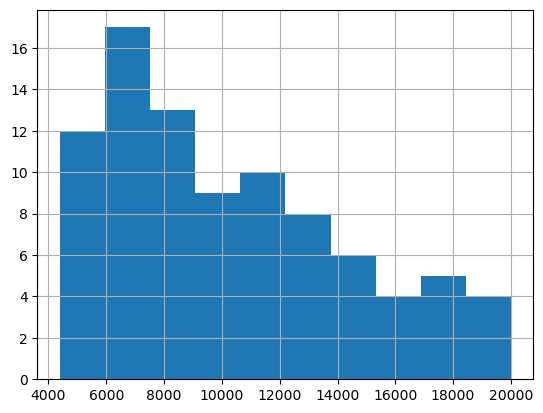

In [47]:
data[(data['power']>MAX_POWER)]['power'].hist()

По гистограмме видим, что есть значения мощности как около 6тыс, так и 20тыс. Можно предположить, что пользователи некорректно добавили лишние 1-2 цифры к мощности, однако мы не можем в качестве решения разделить существующую мощность на 10 или 100. По таблице например, можно заметить, что для Opel Corsa проставлена мощность 5809 - но ни 58л.с., ни 580л.с. не являются адекватными значениями (одно хоть и близко, но слишком мало, а другое - слишком велико). К тому же можно заметить, что иногда мощность совпадает с пробегом, а значит пользователь при заполнении формы объявления просто перепутал поля. К тому же, деление на 10 или 100 не спасёт от наблюдений с мощностью=0, а их основная масса (40 тыс.).
<br>Поэтому по аномальным наблюдениям перезапишем значения мощности медианой по соответствующей модели соответствующего бренда (если медиана существует). В качестве базы для расчета медианы возьмем набор данных без аномалий.

In [48]:
warnings.filterwarnings("ignore")
powermedian = data[(data['power']!=0)&(data['power']<MAX_POWER)].groupby(by=['brand','model'])['power'].median()
data = data.merge(powermedian, how='left',suffixes=[None,'_median'],on=['brand','model'])
data.loc[((data['power']<MIN_POWER)|(data['power']>=MAX_POWER))&(~data['power_median'].isna()),'power'] = data.loc[(data['power']<MIN_POWER)|(data['power']>=MAX_POWER),'power_median']
data.head(2)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,power_median
0,2016-03-24 11:52:17,480,sedan,1993,manual,101.0,golf,150000,6,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57,101.0
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,unknown,125000,5,petrol,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,150.0


По первой строке видим, что значение 0 заменилось на 101, значит, наблюдения с нулевой мощностью заполнились. Проведем проверку:

In [49]:
print('Общее количество наблюдений с аномальной мощностью:',data[(data['power']<MIN_POWER)|(data['power']>MAX_POWER)]['date_crawled'].count())
print('Количество наблюдений с мощностью >4000л.с.: ',data[(data['power']>MAX_POWER)]['date_crawled'].count())
print('Количество наблюдений с мощностью <1 л.с.: ',data[(data['power']<MIN_POWER)]['date_crawled'].count())
print('Количество пропусков:',data['power'].isna().sum())

Общее количество наблюдений с аномальной мощностью: 2
Количество наблюдений с мощностью >4000л.с.:  0
Количество наблюдений с мощностью <1 л.с.:  2
Количество пропусков: 0


Аномалии исправились. Видим, что осталось 2 объявления с мощностью 0, это те объявления, где медиана не определена, то есть по данной модели нет других значений, кроме аномальных. <s>Оставим эти значения как есть.</s> Удалим эти аномалии.

In [50]:
data = data.loc[data['power']!=0]
print('Количество наблюдений с мощностью <1 л.с.: ',data[(data['power']<MIN_POWER)]['date_crawled'].count())


Количество наблюдений с мощностью <1 л.с.:  0


Удалим промежуточное поле.

In [51]:
data = data.drop(['power_median'],axis=1)

#### Price

Рассмотрим аномалии по цене, по описательной статистике мы видели, что существуют объявления с ценой 0 - оценим, сколько таких случаев.

In [52]:
print('Случаев с нулевой ценой:',data[data['price']==0]['date_crawled'].count())
print('Случаев с нулевой ценой,%:',data[data['price']==0]['date_crawled'].count()/len(data)*100)

Случаев с нулевой ценой: 10771
Случаев с нулевой ценой,%: 3.0395042427765566


Таких случаев довольно много в абсолютном количестве, но по сравнению с общим размером выборки, они составляют 3%.
<br>Так как этот признак является целевым, то заполнять его вручную нет смысла, иначе мы будет генерировать самостоятельно данные например по медиане, а затем пытаться их предсказать как мы их сгенерировали, что нелогично.
<br>Удалим данные из выборки.

In [53]:
data = data[data['price']!=0]
print('Случаев с нулевой ценой:',data[data['price']==0]['date_crawled'].count())
print('Случаев с нулевой ценой,%:',data[data['price']==0]['date_crawled'].count()/len(data)*100)
print('Размер оставшейся выборки:',data['price'].count())

Случаев с нулевой ценой: 0
Случаев с нулевой ценой,%: 0.0
Размер оставшейся выборки: 343596


### Удаление столбцов

Столбец 'number_of_pictures' не содержит иных значений, кроме 0. Это поле неинформативно, удалим его.

In [54]:
data['number_of_pictures'].unique()

array([0], dtype=int64)

In [55]:
data = data.drop(['number_of_pictures'],axis=1)

In [56]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'postal_code', 'last_seen'],
      dtype='object')

Удалим столбец postal_code, так как он также не может значимо влиять на стоимость автомобиля.

In [57]:
data = data.drop(['postal_code'],axis=1)
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'last_seen'],
      dtype='object')

Удалим также столбцы 'date_crawled','date_created','last_seen', так как они относятся к дате публикации объявления и активности пользователя, но не могут характеризовать стоимость автомобиля.

In [58]:
data = data.drop(['date_crawled','date_created','last_seen'],axis=1)
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

### Вывод по этапу подготовки данных

<br>В ходе подготовки данных было проделано:
- были загружены исходные данные и проведен первичный анализ
- наименования столбцов было приведено к  классическому виду (змеиный регистр)
- типы данных были приведены к соответствующим им данным:
    - 'date_crawled', 'date_created', 'last_seen' - к типу datetime
    - 'postal_code' - к строке
- Были заполнены пропуски в данных:
    - в поле 'model' -   значением 'unknown'
    - в поле 'vehicle_type' - модой в разрезе бренда и модели
    - в поле 'repaired' -  значением 'no'
    - в поле 'gearbox' -  модой в разрезе бренда и модели
    - в поле 'fuel_type' - модой в разрезе бренда и модели
- Были изучены и исправлены аномалии в данных:
    - в поле 'registration_year' аномалии скорректирваны в зависимости от пробега автомобиля
    - в поле 'registration_month' аномалии (нулевой месяц) заполнены серединой года, т.е. 6м месяцем.
    - в поле 'power' аномальные значения мощности заполнены медианой в разрезе бренда и модели
    - объявления с отсутствующими значениями в поле 'price' удалены, т.к. поле является целевым признаком
- Был удалены следующие столбцы:
    - столбец 'number_of_pictures', так как поле не содержит иных значений, кроме 0.
    - столбцы 'date_crawled', 'date_created', 'last_seen' также удалены, так они не характеризуют продаваемый автомобиль, а относятся к дате публикации объявления и активности пользователя на сайте.

## Анализ сформированных данных

Построим заново диаграмму рассеяния между признаками.

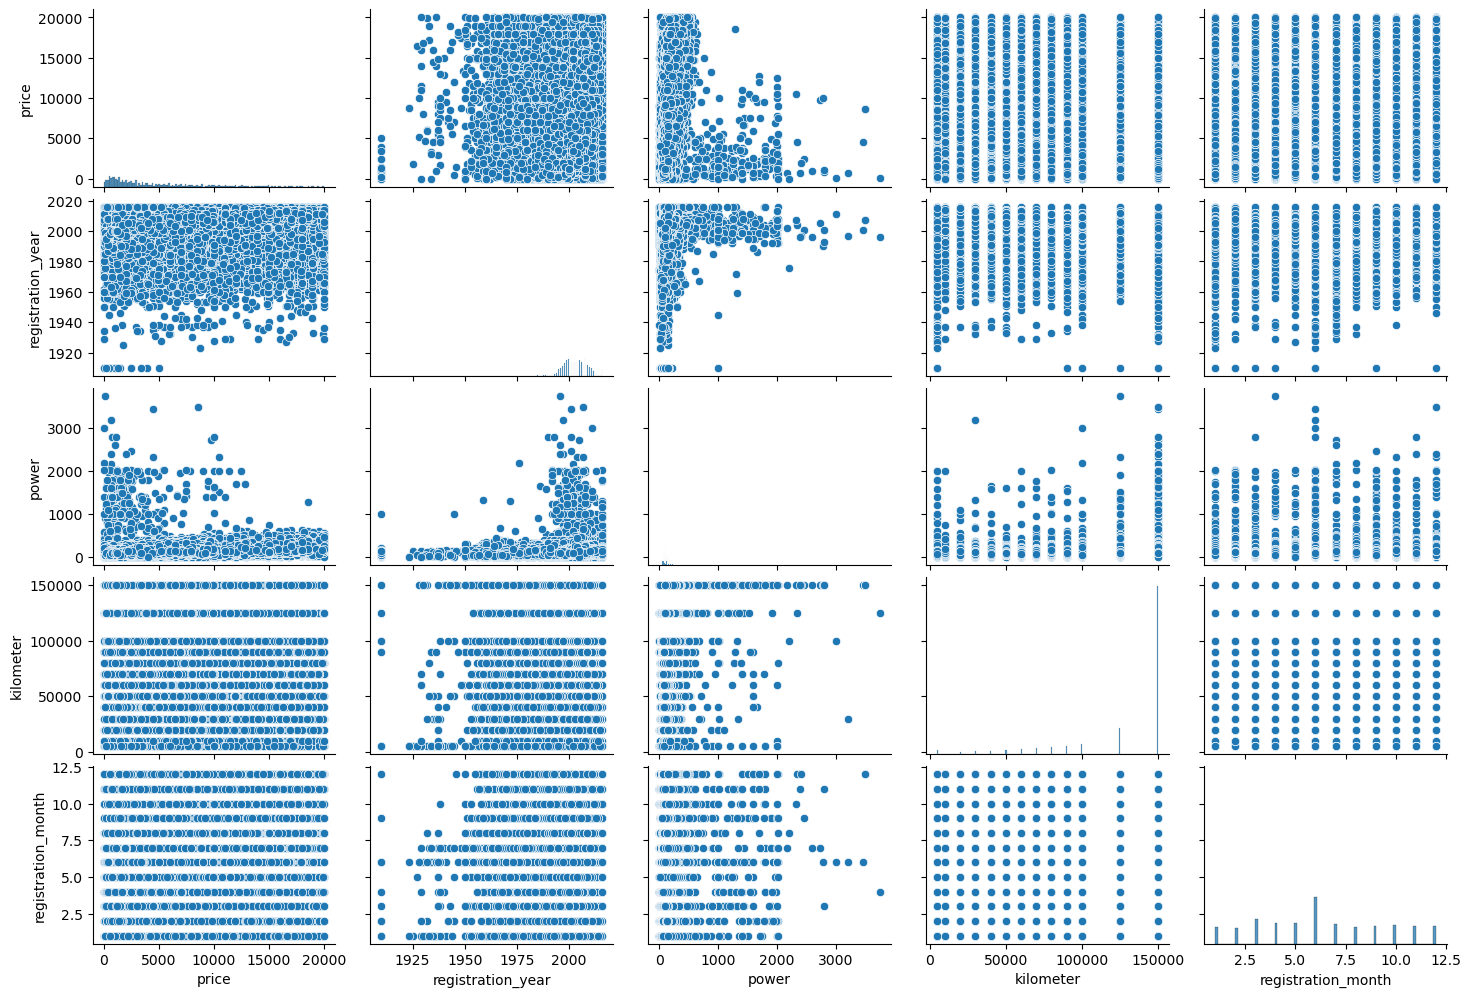

In [59]:
sns.pairplot(data)
plt.gcf().set_size_inches(15, 10)
plt.show()

В целом мало что изменилось по сравнению с предыдущим запуском графика. Какие выводы все же можно сделать:
- наблюдается рост мощности мощности машин с течение времени (чем ближе registration_year к текущему году, тем больше машин с высокой мощностью)
- между мощностью и ценой наблюдается как-будто обратная зависимость, однако это скорее особенность аномальных данных, котоыре мы не затронули. Чаще всего мощность машин все-таки не превышает 500л.с., мы же брали в качестве ограничения максимальную мощность в 4000л.с. поэтому если посмотреть в нижнюю часть графика, где скорее всего расположеныы наиболее реальные данные, то можно увидеть небольшое увеличение плоности графика и положительную корреляцию.
- основная доля объявлений - по машинам от 1950 года регистрации и позже.

Изучим корреляцию между признаками.

In [60]:
data_corr = data.corr(numeric_only=True)
data_corr

,price,registration_year,power,kilometer,registration_month
price,1.000000,0.415444,0.395858,-0.350501,0.018027
registration_year,0.415444,1.000000,0.085538,-0.219176,0.014682
power,0.395858,0.085538,1.000000,0.077517,0.021037
kilometer,-0.350501,-0.219176,0.077517,1.000000,0.009101
registration_month,0.018027,0.014682,0.021037,0.009101,1.000000


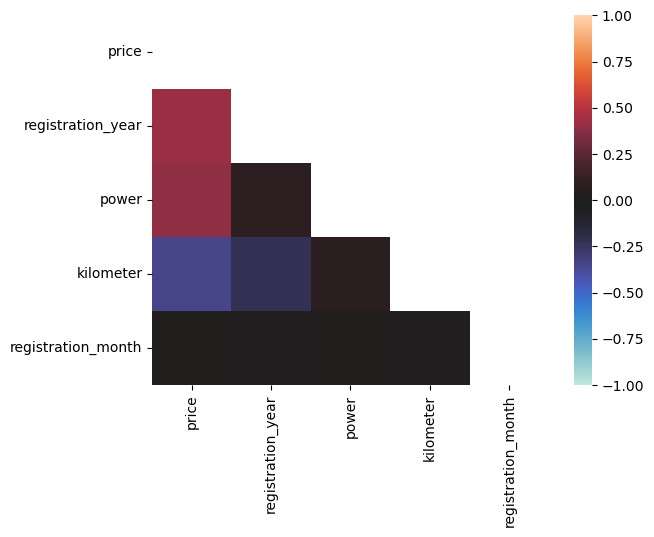

In [61]:
matrix = np.triu(data_corr)
sns.heatmap(data_corr, annot = True, vmin=-1, vmax=1, center= 0, mask=matrix);

Видим, что наибольшая корреляция наблюдается между признаками:
- registration_year & price (0,42)
- power & price (0,4)
<br>Это средний уровень корреляции. Можно в целом сделать вывод, что цена в наибольшей степени зависит от этих двух признаков, однако каждый из них по отдельности не может служить достаточным для прогнозирования цены - она зависит от совокупности нескольких признаков.
<br>Наблюдается отрицательная корреляция между признаками:
- ценой и пробегом авто (что логично)
- годом регистрации авто и пробегом (что тоже логично - чем моложе авто, тем меньше пробег)
<br> Корреляция между остальными признаками (и к цене в том числе) не превышает 0,01, что говорит о полном отсутствием какой-либо зависимости.

Мультиколлинеарности между признаками не наблюдается.

## Обучение моделей

### Создание скорера

Создадим функцию RMSE, на основе которой будем оценивать модели.

In [62]:
def get_rmse(target, predictions):
    return (mean_squared_error(target, predictions))**0.5

scorer_rmse = make_scorer(get_rmse, greater_is_better = False)

### Дерево решений (поиск в цикле)

Создадим подвыборки

In [63]:
features_oe = data.drop(['price'], axis=1)
target_oe = data['price']

In [64]:

features_train_oe, features_validtest_oe, target_train_oe, target_validtest_oe = train_test_split(
features_oe, target_oe, test_size=0.4, random_state=p_random_state #, stratify=target 
) # отделим 40% данных для валидационной и тествой выборки

features_valid_oe, features_test_oe, target_valid_oe, target_test_oe = train_test_split(
features_validtest_oe, target_validtest_oe, test_size=0.5, random_state=p_random_state) # отделим 20% данных для тестовой выборки


In [65]:
print('features_train_oe',features_train_oe.shape)
print('target_train_oe',target_train_oe.shape)
print('features_valid_oe',features_valid_oe.shape)
print('target_valid_oe',target_valid_oe.shape)
print('features_test_oe',features_test_oe.shape)
print('target_test_oe',target_test_oe.shape)

features_train_oe (206157, 10)
target_train_oe (206157,)
features_valid_oe (68719, 10)
target_valid_oe (68719,)
features_test_oe (68720, 10)
target_test_oe (68720,)


Закодируем признаки

In [66]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
encoder.fit(features_train_oe)
#data_oe = pd.DataFrame(encoder.transform(data),columns=data.columns)
features_train_oe = encoder.transform(features_train_oe)
features_valid_oe = encoder.transform(features_valid_oe)
features_test_oe = encoder.transform(features_test_oe)

In [67]:
features_train_oe

array([[ 4., 78.,  1., ...,  5., 39.,  0.],
       [ 8., 80.,  1., ...,  5.,  2.,  1.],
       [ 2., 76.,  1., ...,  5., 19.,  0.],
       ...,
       [ 5., 67.,  1., ...,  5., 24.,  0.],
       [ 4., 72.,  0., ...,  5.,  4.,  0.],
       [ 5., 72.,  1., ...,  5., 10.,  0.]])

Подготовим шаблон таблицы для поиска наилучшей модели дерева через цикл.

In [68]:
models_results = pd.DataFrame(columns=['model_type', 'model_name','depth','RMSE'])
models_results

,model_type,model_name,depth,RMSE


Рассмотрим модель дерева решений с глубиной от 2 до 100

In [70]:
start = time.time()
best_model = None
best_result_tree1 = 10000
best_depth_tree1 = 0
for depth in range(2, 100):
    model = DecisionTreeRegressor(random_state=p_random_state , max_depth=depth) # инициализируем модель DecisionTreeRegressor с параметром random_state=12345 и max_depth=depth
    model_name = 'DecisionTreeRegressor_'+str(depth)
    model.fit(features_train_oe, target_train_oe) # обучим модель на тренировочной выборке
    predictions_valid = model.predict(features_valid_oe) # получим предсказания модели на валидационной выборке
    result = (mean_squared_error(target_valid_oe, predictions_valid))**0.5# посчитаем значение метрики rmse на валидационной выборке
    result_row = pd.DataFrame(['DTR',model_name,depth,result]).T
    result_row.columns = models_results.columns
    models_results = pd.concat([models_results,result_row]).reset_index(drop=True)
    #models_results = models_results.append(result_row,ignore_index = True)
    if result < best_result_tree1:
        best_model = model
        best_depth_tree1 = depth
        best_result_tree1=result
end = time.time() 
result_time_tree1 = end - start
print("RMSE наилучшей модели на валидационной выборке:", best_result_tree1, "Глубина дерева:", best_depth_tree1)
print('Время выполнения:',result_time_tree1)

RMSE наилучшей модели на валидационной выборке: 2037.9662482111983 Глубина дерева: 13
Время выполнения: 96.60115671157837


In [71]:
display(models_results.sort_values(by='RMSE').head(20).style.background_gradient(cmap='Blues', axis=0,subset=['RMSE']))

,model_type,model_name,depth,RMSE
11,DTR,DecisionTreeRegressor_13,13,2037.966248
12,DTR,DecisionTreeRegressor_14,14,2039.630373
13,DTR,DecisionTreeRegressor_15,15,2040.139968
14,DTR,DecisionTreeRegressor_16,16,2044.821306
10,DTR,DecisionTreeRegressor_12,12,2054.355861
15,DTR,DecisionTreeRegressor_17,17,2076.114150
9,DTR,DecisionTreeRegressor_11,11,2080.349421
16,DTR,DecisionTreeRegressor_18,18,2104.189293
8,DTR,DecisionTreeRegressor_10,10,2115.139823
17,DTR,DecisionTreeRegressor_19,19,2129.938591


Видим, что даже при глубине дерева до 100, наилучшим результатом оказалось дерево с глубиной 13 - значение RMSE составило примерно 2038.

### Дерево решений (GridSearchCV)

Повторно кодировать признаки нет необходимости.

Создадим подвыборки

In [72]:
features_train_cv_oe, features_test_cv_oe, target_train_cv_oe, target_test_cv_oe = train_test_split(
features_oe, target_oe, test_size=0.25, random_state=p_random_state) # отделим 40% данных для валидационной и тествой выборки


In [73]:
print('features_train_cv_oe',features_train_cv_oe.shape)
print('target_train_cv_oe',target_train_cv_oe.shape)
print('features_test_cv_oe',features_test_cv_oe.shape)
print('target_test_cv_oe',target_test_cv_oe.shape)

features_train_cv_oe (257697, 10)
target_train_cv_oe (257697,)
features_test_cv_oe (85899, 10)
target_test_cv_oe (85899,)


Проверим алгоритм, аналогичный тому, что выше, но с примененем GridSearchCV. В качестве параметров глубины дерева также возьмем глубину от 2 до 100, чтобы корректно сравнить время поиска модели с предыдущим поиском в цикле.

In [74]:
start = time.time()
#model_tree_gscv = DecisionTreeRegressor()

pipe = Pipeline([
        #('scale', StandardScaler()),
        ('encode',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)),
        ('gscv', DecisionTreeRegressor())])

params = {'gscv__max_depth': range(2, 100),
        'gscv__random_state':[p_random_state],
        'gscv__splitter':['best', 'random'] }

gscv = GridSearchCV(pipe, params, scoring=scorer_rmse, cv=5)

#model_tree_gscv_search.fit(features_train_cv_oe, target_train_cv_oe)
gscv.fit(features_train_cv_oe, target_train_cv_oe)

end = time.time()
result_time_tree2 = end - start
print('Время выполнения:',result_time_tree2)

Время выполнения: 1238.5014824867249


In [75]:
#print(model_tree_gscv_search.best_estimator_)
#print(model_tree_gscv_search.best_params_)
best_result_tree2 = abs(gscv.best_score_)
best_depth_tree2 = gscv.best_params_['gscv__max_depth']
print("RMSE наилучшей модели на валидационной выборке:", best_result_tree2, "Глубина дерева:", best_depth_tree2)
print('Время выполнения:',result_time_tree2)

RMSE наилучшей модели на валидационной выборке: 2054.7212376879606 Глубина дерева: 13
Время выполнения: 1238.5014824867249


Видим, что поиск через GridSearch дал такой же результат по глубине дерева, но метрика получилась чуть-чуть похуже  - дерево с глубиной 13 и метрику RMSE=2054 (в цикле глубина была 13 и метрика 2038), однако время выполнения существенно больше >1000сек, вместо ~70сек в предыдущем варианте. 

### Линейная регрессия

Попробуем сначала разбить на выборки, затем провести масштабирование количественных признаков и затем закодировать категориальные (т.к. масштабирование после кодирования не работает).

In [82]:
data_ohe = data.copy()
features_ohe = data_ohe.drop(['price'], axis=1)# извлечем признаки
target_ohe = data_ohe['price'] # извлечем целевой признак

features_train_ohe, features_validtest_ohe, target_train_ohe, target_validtest_ohe = train_test_split(
features_ohe, target_ohe, test_size=0.4, random_state=p_random_state) # отделим 40% данных для валидационной и тествой выборки

features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(
features_validtest_ohe, target_validtest_ohe, test_size=0.5, random_state=p_random_state) # отделим 20% данных для тестовой выборки


In [83]:
print('features_train_ohe',features_train_ohe.shape)
print('target_train_ohe',target_train_ohe.shape)
print('features_valid_ohe',features_valid_ohe.shape)
print('target_valid_ohe',target_valid_ohe.shape)
print('features_test_ohe',features_test_ohe.shape)
print('target_test_ohe',target_test_ohe.shape)

features_train_ohe (206157, 10)
target_train_ohe (206157,)
features_valid_ohe (68719, 10)
target_valid_ohe (68719,)
features_test_ohe (68720, 10)
target_test_ohe (68720,)


In [84]:
numeric = ['power','kilometer']
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])
pd.options.mode.chained_assignment = None

In [85]:
features_train_ohe.head(2)

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
134252,sedan,2007,manual,0.37865,c_reihe,0.57848,2,petrol,volvo,no
234224,wagon,2009,manual,0.34835,3er,0.57848,6,petrol,bmw,yes


In [86]:
ohe_features = features_train_ohe.select_dtypes(include='object').columns.to_list()
print(ohe_features)

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']


In [87]:
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train_ohe[ohe_features])

OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)

In [88]:
features_train_ohe= encoder_ohe.transform(features_train_ohe[ohe_features])
features_valid_ohe= encoder_ohe.transform(features_valid_ohe[ohe_features])
features_test_ohe= encoder_ohe.transform(features_test_ohe[ohe_features])
print('features_train_ohe',features_train_ohe.shape)
print('target_train_ohe',target_train_ohe.shape)
print('features_valid_ohe',features_valid_ohe.shape)
print('target_valid_ohe',target_valid_ohe.shape)
print('features_test_ohe',features_test_ohe.shape)
print('target_test_ohe',target_test_ohe.shape)

features_train_ohe (206157, 309)
target_train_ohe (206157,)
features_valid_ohe (68719, 309)
target_valid_ohe (68719,)
features_test_ohe (68720, 309)
target_test_ohe (68720,)


In [89]:
start = time.time()

model = LinearRegression()# инициализируем модель LinearRegression
model.fit(features_train_ohe, target_train_ohe) # обучим модель на тренировочной выборке
predictions_valid = model.predict(features_valid_ohe) # получим предсказания модели на валидационной выборке

best_result_linreg1 = (mean_squared_error(target_valid_ohe,predictions_valid))**0.5# посчитаем значение метрики RMSE на валидационной выборке
end = time.time()
result_time_linreg1 = end - start
print("RMSE модели линейной регрессии на валидационной выборке:", best_result_linreg1)
print('Время выполнения:',result_time_linreg1)

RMSE модели линейной регрессии на валидационной выборке: 3614.84044928265
Время выполнения: 3.3569560050964355


### Линейная регрессия с кроссвалидацией

In [90]:
del data_ohe, features_ohe, target_ohe, \
features_train_ohe, features_validtest_ohe, target_train_ohe, target_validtest_ohe, \
features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe, \
numeric, scaler, ohe_features, encoder_ohe, model, predictions_valid 


In [91]:
data_ohe = data.copy()
features_ohe = data_ohe.drop(['price'], axis=1)# извлечем признаки
target_ohe = data_ohe['price'] # извлечем целевой признак


In [92]:
features_train_ohe_cv, features_test_ohe_cv, target_train_ohe_cv, target_test_ohe_cv = train_test_split(
features_ohe, target_ohe, test_size=0.25, random_state=p_random_state) # отделим 40% данных для валидационной и тествой выборки


In [93]:
print('features_train_ohe_cv',features_train_ohe_cv.shape)
print('target_train_ohe_cv',target_train_ohe_cv.shape)
print('features_test_ohe_cv',features_test_ohe_cv.shape)
print('target_test_ohe_cv',target_test_ohe_cv.shape)

features_train_ohe_cv (257697, 10)
target_train_ohe_cv (257697,)
features_test_ohe_cv (85899, 10)
target_test_ohe_cv (85899,)


In [94]:
scorer_rmse = make_scorer(get_rmse, greater_is_better = False)

numeric = ['power','kilometer']

pd.options.mode.chained_assignment = None

ohe_features = features_train_ohe_cv.select_dtypes(include='object').columns.to_list()

col_transformer = ColumnTransformer(transformers= [
     # Scaler on our numeric ordinal and interval data
    ("scaler", StandardScaler(), numeric),     
     # OHE catagorical string data
    ("ohe", OneHotEncoder(handle_unknown='ignore', sparse=False), ohe_features)],     
    remainder="passthrough")

del data_ohe, features_ohe, target_ohe

start = time.time()

pipe = Pipeline([
        ('col_transformer', col_transformer),
        ('model', LinearRegression())])

scores = cross_val_score(pipe, features_train_ohe_cv, target_train_ohe_cv,scoring=scorer_rmse, cv=5) 
best_result_linreg_cv = abs(scores.mean())

end = time.time()
result_time_linreg_cv = end - start
print('RMSE модели на линейной регрессии на тренировочной выборке с кроссвалидацией:',best_result_linreg_cv)
print('Время выполнения:',result_time_linreg_cv)

RMSE модели на линейной регрессии на тренировочной выборке с кроссвалидацией: 2941.02174563565
Время выполнения: 21.079474449157715


Кроссвалидация помогла немного улучшить результаты - метрика 2941, время - 134сек.

### Регрессия LightGBM

Попробуем использовать моделирование через библиотеку LightGBM.

In [95]:
data_lgbm = data.copy()

In [96]:
for c in data_lgbm.columns:
    col_type = data_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data_lgbm[c] = data_lgbm[c].astype('category')
data_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343596 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               343596 non-null  int64   
 1   vehicle_type        343596 non-null  category
 2   registration_year   343596 non-null  int64   
 3   gearbox             343596 non-null  category
 4   power               343596 non-null  float64 
 5   model               343596 non-null  category
 6   kilometer           343596 non-null  int64   
 7   registration_month  343596 non-null  int64   
 8   fuel_type           343596 non-null  category
 9   brand               343596 non-null  category
 10  repaired            343596 non-null  category
dtypes: category(6), float64(1), int64(4)
memory usage: 18.0 MB


In [97]:
features_lgbm = data_lgbm.drop(['price'], axis=1)# извлечем признаки
target_lgbm = data_lgbm['price'] # извлечем целевой признак


In [98]:
features_train_lgbm, features_test_lgbm, target_train_lgbm, target_test_lgbm = \
train_test_split(features_lgbm, target_lgbm, test_size=0.25, random_state=p_random_state \
                # , stratify=target_lgbm
                )

In [99]:
print('features_train_lgbm',features_train_lgbm.shape)
print('target_train_lgbm',target_train_lgbm.shape)
print('features_test_lgbm',features_test_lgbm.shape)
print('target_test_lgbm',target_test_lgbm.shape)

features_train_lgbm (257697, 10)
target_train_lgbm (257697,)
features_test_lgbm (85899, 10)
target_test_lgbm (85899,)


In [100]:
start = time.time()
model_lgbm = LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_lgbm, features_train_lgbm, target_train_lgbm, scoring=scorer_rmse, cv=5)

end = time.time()
result_time_lgbm = end - start
best_result_linreg_lgbm = abs(n_scores.mean())
print('RMSE модели на модели регрессии LightGBM на тренировочной выборке с кроссвалидацией: ', best_result_linreg_lgbm)
print('Время выполнения:',result_time_lgbm)

  File "C:\Users\PC\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 206157, number of used features: 10
[LightGBM] [Info] Start training from score 4565.970440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 206157, number of used features: 10
[LightGBM] [Info] Start training from score 4560.191199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

## Анализ моделей

### Анализ полученных результатов

In [102]:
print('Проанализируем полученные результаты')
print('Модель поиска дерева решений в цикле:')
print('время выполнения = ', result_time_tree1)
print('RMSE=', best_result_tree1)
print()
print('Модель поиска дерева решений через GridSearchCV:')
print('время выполнения= ',  result_time_tree2)
print('RMSE=', best_result_tree2)
print()
print('Модель простой линейной регрессии (ohe):')
print('время выполнения= ', result_time_linreg1)
print('RMSE=', best_result_linreg1)
print()
print('Модель линейной регрессии с кроссвалидацией (ohe_cv):')
print('время выполнения= ', result_time_linreg_cv)
print('RMSE=', best_result_linreg_cv)
print()
print('Модель LightGBM:')
print('время выполнения= ', result_time_lgbm)
print('RMSE=', best_result_linreg_lgbm)

print('Видим, что наилучшие результаты дала модель регрессии LightGBM.') 


Проанализируем полученные результаты
Модель поиска дерева решений в цикле:
время выполнения =  96.60115671157837
RMSE= 2037.9662482111983

Модель поиска дерева решений через GridSearchCV:
время выполнения=  1238.5014824867249
RMSE= 2054.7212376879606

Модель простой линейной регрессии (ohe):
время выполнения=  3.3569560050964355
RMSE= 3614.84044928265

Модель линейной регрессии с кроссвалидацией (ohe_cv):
время выполнения=  21.079474449157715
RMSE= 2941.02174563565

Модель LightGBM:
время выполнения=  3.132761001586914
RMSE= 1797.4987067807833
Видим, что наилучшие результаты дала модель регрессии LightGBM.


### Проверим модель на адекватность

In [103]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train_ohe_cv, target_train_ohe_cv)
dummy_predict = dummy_regr.predict(features_test_ohe_cv)
dummy_test_rmse = get_rmse(target_test_ohe_cv,dummy_predict)
print('Оценка RMSE на модели dummy:',dummy_test_rmse)


Оценка RMSE на модели dummy: 4517.504823975432


Видим, что на случайной модели значение RMSE гораздо выше, чем на модели LightGBM, значит модель дейтствительно предсказывает результаты лучше, чем случайная модель.

### Проверка модели на тестовой выборке

In [104]:
model_lgbm = LGBMRegressor()
model_lgbm.fit(features_train_lgbm, target_train_lgbm) # обучим модель на тренировочной выборке
predictions_valid = model_lgbm.predict(features_test_lgbm) # получим предсказания модели на валидационной выборке

final_result_lgbm= (mean_squared_error(target_test_lgbm,predictions_valid))**0.5# посчитаем значение метрики RMSE на валидационной выборке
print('Финальный результат RMSE модели LightGBM на тестовой выборке:',final_result_lgbm)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 257697, number of used features: 10
[LightGBM] [Info] Start training from score 4559.872300
Финальный результат RMSE модели LightGBM на тестовой выборке: 1784.055457458889


На тестовой выборке получился результат 1784.

### Feature importance

Оценим важность фичей в текущей модели:

model                 782
registration_year     739
power                 525
kilometer             310
brand                 260
vehicle_type          179
repaired               76
registration_month     70
gearbox                41
fuel_type              18
dtype: int32


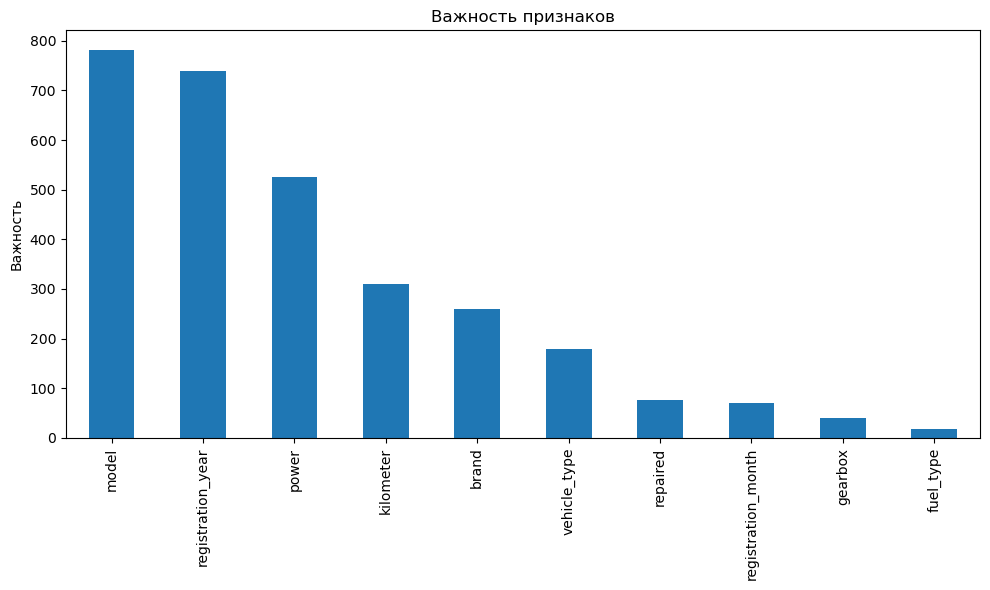

In [105]:
feature_importance = pd.Series(model_lgbm.feature_importances_, \
                         features_train_lgbm.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,6))
feature_importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

print(feature_importance)

## Итоговый вывод

<br>Перед началом исследования стояла цель: спрогнозировать цену автомобилей в объявлениях по предоставленным признакам (Бренд, Модель, Мощность, Год выпуска авто и т.д.)
<br>Для обучения и тестирования моделей была предоставлена выгрузка базы объявлений с параметрами автомобилей и их фактическими ценами.

<br>**В ходе подготовки данных было сделано:**
- были загружены исходные данные и проведен первичный анализ
- наименования столбцов было приведено к  классическому виду (змеиный регистр)
- типы данных были приведены к соответствующим им данным:
    - 'date_crawled', 'date_created', 'last_seen' - к типу datetime
    - 'postal_code' - к строке
- Были заполнены пропуски в данных:
    - в поле 'model' -   значением 'unknown'
    - в поле 'vehicle_type' - модой в разрезе бренда и модели
    - в поле 'repaired' -  значением 'no'
    - в поле 'gearbox' -  модой в разрезе бренда и модели
    - в поле 'fuel_type' - модой в разрезе бренда и модели
- Были изучены и исправлены аномалии в данных:
    - в поле 'registration_year' аномалии скорректирваны в зависимости от пробега автомобиля
    - в поле 'registration_month' аномалии (нулевой месяц) заполнены серединой года, т.е. 6м месяцем.
    - в поле 'power' аномальные значения мощности заполнены медианой в разрезе бренда и модели
    - объявления с отсутствующими значениями в поле 'price' удалены, т.к. поле является целевым признаком
- Был удалены следующие столбцы:
    - столбец 'number_of_pictures', так как поле не содержит иных значений, кроме 0.
    - столбцы 'date_crawled', 'date_created', 'last_seen' также удалены, так они не характеризуют продаваемый автомобиль, а относятся к дате публикации объявления и активности пользователя на сайте.

<br>**Исследовательский анализ показал:**
- наблюдается рост мощности мощности машин с течение времени (чем ближе registration_year к текущему году, тем больше машин с высокой мощностью)
- между мощностью и ценой наблюдается как-будто обратная зависимость, однако это скорее особенность аномальных данных, котоыре мы не затронули. Чаще всего мощность машин все-таки не превышает 500л.с., мы же брали в качестве ограничения максимальную мощность в 4000л.с. поэтому если посмотреть в нижнюю часть графика, где скорее всего расположеныы наиболее реальные данные, то можно увидеть небольшое увеличение плоности графика и положительную корреляцию.
- основная доля объявлений - по машинам от 1950 года регистрации и позже.
- Наибольшая корреляция наблюдается между признаками:
    - registration_year & price (0,42)
    - power & price (0,4)
<br>Это средний уровень корреляции. Можно в целом сделать вывод, что цена в наибольшей степени зависит от этих двух признаков, однако каждый из них по отдельности не может служить достаточным для прогнозирования цены - она зависит от совокупности нескольких признаков.
- Наблюдается отрицательная корреляция между признаками:
    - ценой и пробегом авто (что логично)
    - годом регистрации авто и пробегом (что тоже логично - чем моложе авто, тем меньше пробег)
- Корреляция между остальными признаками (и к цене в том числе) не превышает 0,01, что говорит о полном отсутствием какой-либо зависимости.
- Мультиколлинеарности между признаками не наблюдается.


<br>**В ходе поиска модели с наилучшими показателями было сделано:**
- были рассмотрены следующие виды моделей:
    - дерево решений (с глубиной от 2 до 100) с поиском в цикле
    - дерево решений (с глубиной от 2 до 100) с поиском через GridSearch
    - линейная регрессия без кроссвалидации
    - линейная регрессия с кроссвалидацией
    - модель регрессии LightGBM
- в качестве метрики качества была использована функция RMSE
<br>Для каждой из моделей также было замерено время обучения и предсказания модели
<br>Полученные результаты:
- Модель поиска дерева решений в цикле:
    - время выполнения =  82.88305640220642
    - RMSE= 2037.9662482111983

- Модель поиска дерева решений через GridSearchCV:
    - время выполнения=  1141.9148917198181
    - RMSE= 2054.7212376879606

- Модель простой линейной регрессии (get_dummies):
    - время выполнения=  20.409640789031982
    - RMSE= 2926.6544079492505

- Модель простой линейной регрессии (ohe):
    - время выполнения=  22.002384901046753
    - RMSE= 3614.8411474509016

- Модель линейной регрессии с кроссвалидацией (ohe_cv):
    - время выполнения=  134.4584105014801
    - RMSE= 2941.0234617452957

- Модель LightGBM:
    - время выполнения=  877.5172863006592
    - RMSE= 1797.4987067807833
    
<br>Наилучшая из найденных моделей - модель LightGBM.
<br>Минимальное значение RMSE на валидационной выборке - 1797.

<br>**Тестирование модели:**
- тестирование модели показало следующие результаты: RMSE = 
- также модель была проверена против случайной модели. Показатель RMSE случайной модели - 4517, что гораздо выше модели LightGBM, значит, обученная модель LightGBM работает лучше.

<br>**Оценка важности признаков:**
<br>Оценка важности признаков показала, что сильнее всего влияют год регистрации, мощность и пробег авто:
- registration_year     0.529297
- power                 0.276632
- kilometer             0.083210
- brand                 0.031690
- vehicle_type          0.031307
- model                 0.020778
- repaired              0.017140
- registration_month    0.007399
- gearbox               0.002012
- fuel_type             0.000535